#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

In [1]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
from TAVIE import *
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
from CompetingMethods import *
from time import perf_counter
from tqdm import tqdm, trange
from scipy.stats import t
import pandas as pd

## Comparing our TAVIE algorithm for Laplace location-scale family (Type I)

**Competing method: black-box variational inference (BBVI)**

In [4]:
# TAVIE model initialization
laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

# Experiment parameters
n = 10000
p = 6
tau2_true = 3
num_reps = 50

# Containers for metrics
mse_beta_BBVI = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_tau2_BBVI = np.zeros(num_reps)
mse_tau2_TAVIE = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)

# True beta vector
beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# Main loop with progress bar for TAVIE and BBVI results
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    
    error = np.random.laplace(size=n, scale=1/np.sqrt(tau2_true))
    y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

    # TAVIE estimator
    t0 = perf_counter()
    laplace_model.fit(X, y, verbose=False) # fitting the TAVIE model for laplace
    time_TAVIE[rep] = perf_counter() - t0
    beta_est, tau2_est = laplace_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est - beta_true)**2)
    mse_tau2_TAVIE[rep] = (tau2_est - tau2_true)**2
    
    # BBVI estimator
    t0 = perf_counter()
    res2 = BBVI_Laplace(X_bbvi, y)
    time_BBVI[rep] = perf_counter() - t0
    beta_est2 = res2['beta_mean']
    tau2_est2 = res2['tau2_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est2 - beta_true)**2)
    mse_tau2_BBVI[rep] = (tau2_est2 - tau2_true)**2

Repetitions: 100%|██████████████████████████████| 50/50 [03:29<00:00,  4.20s/it]


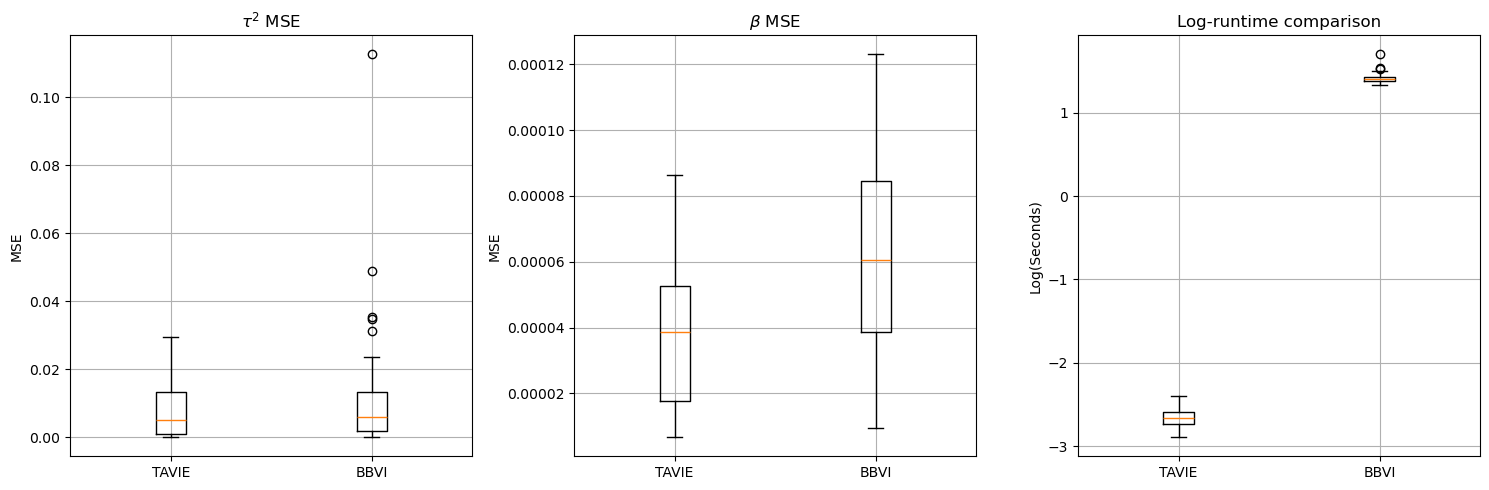

In [5]:
# Plotting results for TAVIE and BBVI
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Tau^2 MSE comparison
axes[0].boxplot([mse_tau2_TAVIE, mse_tau2_BBVI], tick_labels=['TAVIE', 'BBVI'])
axes[0].set_title(r'$\tau^2$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([mse_beta_TAVIE, mse_beta_BBVI], tick_labels=['TAVIE', 'BBVI'])
axes[1].set_title(r'$\beta$ MSE')
axes[1].set_ylabel('MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_BBVI)], tick_labels=['TAVIE', 'BBVI'])
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Student's-t location-scale family (Type I)

**Competing methods:**
* **black-box variational inference (BBVI)** and
* **mean-field variational inference (MFVI)**

The MFVI for Student's-t has been implemented in CompetingMethods/mfvi.py following Wand et al., 2011 <doi:10.1214/11-BA631>.

In [8]:
# TAVIE model initialization
t_model = TAVIE_loc_scale(family="student", fit_intercept=True)

# Experiment parameters
n = 10000
p = 6
nu_true = 3
tau2_true = 4
num_reps = 100

# Containers for metrics
mse_beta_MFVI = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_tau2_MFVI = np.zeros(num_reps)
mse_tau2_BBVI = np.zeros(num_reps)
mse_tau2_TAVIE = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_MFVI = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)

# True beta vector
beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    
    error = t.rvs(df=nu_true, size=n) / np.sqrt(tau2_true)
    y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

    # TAVIE estimator
    t0 = perf_counter()
    t_model.fit(X, y, nu=nu_true, verbose=False) # fitting the TAVIE model for Student's-t
    time_TAVIE[rep] = perf_counter() - t0
    beta_est, tau2_est = t_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est - beta_true)**2)
    mse_tau2_TAVIE[rep] = (tau2_est - tau2_true)**2
    

    # MFVI estimator
    t0 = perf_counter()
    beta_hat, sigma_sq_hat, nu_hat = MFVI_Student(X_bbvi, y, 
                                                  mu_beta=np.zeros(p+1), Sigma_beta=np.eye(p+1), 
                                                  A=2, B=2, nu_min=2.0, 
                                                  nu_max=20.0, tol=1e-6, verbose = False)
    time_MFVI = perf_counter() - t0
    beta_est2 = beta_hat
    tau2_est2 = 1/sigma_sq_hat
    mse_beta_MFVI[rep] = np.mean((beta_est2 - beta_true)**2)
    mse_tau2_MFVI[rep] = (tau2_est2 - tau2_true)**2

    # BBVI estimator
    t0 = perf_counter()
    res2 = BBVI_student(X_bbvi, y, nu=nu_true)
    time_BBVI[rep] = perf_counter() - t0
    beta_est3 = res2['beta_mean']
    tau2_est3 = res2['tau2_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est3 - beta_true)**2)
    mse_tau2_BBVI[rep] = (tau2_est3 - tau2_true)**2

Repetitions: 100%|████████████████████████████| 100/100 [13:30<00:00,  8.10s/it]


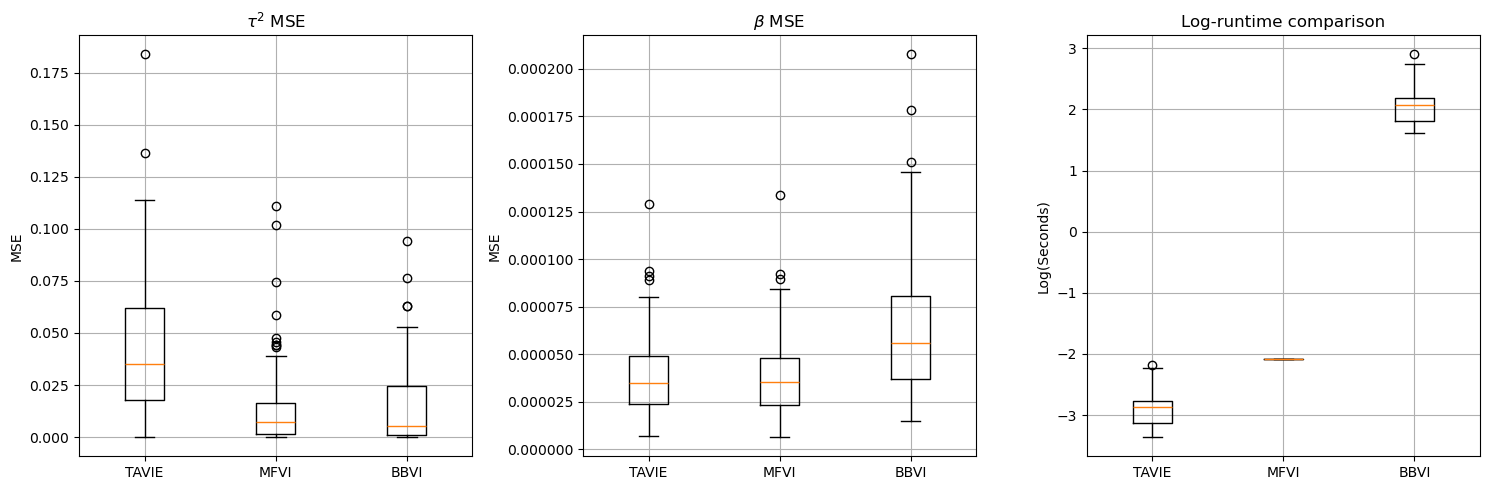

In [10]:
# Plotting results for TAVI, MFVI, and BBVI
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Tau^2 MSE comparison
axes[0].boxplot([mse_tau2_TAVIE, mse_tau2_MFVI, mse_tau2_BBVI], tick_labels=['TAVIE', 'MFVI', 'BBVI'])
axes[0].set_title(r'$\tau^2$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([mse_beta_TAVIE, mse_beta_MFVI, mse_beta_BBVI], tick_labels=['TAVIE', 'MFVI', 'BBVI'])
axes[1].set_title(r'$\beta$ MSE')
axes[1].set_ylabel('MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_MFVI), np.log(time_BBVI)], tick_labels=['TAVIE', 'MFVI', 'BBVI'])
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Logistic family (Type II)

**Competing methods:**
* **black-box variational inference (BBVI)**,
* **mean-field variational inference (MFVI)**, and
* **stochastic variational inference (SVI)**

The MFVI (CAVI) and SVI for Bayesian logistic regression has been implemented in CompetingMethods/mfvi.py following Durante and Rigon, 2019 <https://doi.org/10.1214/19-STS712>.

In [11]:
# TAVIE model initialization
logit_model = TAVIE_type_II(family="binomial", fit_intercept=True)

# Experiment parameters
n = 10000
p = 6
num_reps = 50

# Containers for metrics
mse_beta_CAVI = np.zeros(num_reps)
mse_beta_SVI = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_CAVI = np.zeros(num_reps)
time_SVI = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)

prior = {
    'mu'   : np.zeros(p+1),
    'Sigma': np.eye(p+1)
}

beta_true = np.random.normal(loc=2.0, scale=1.0, size=p+1)

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
     
    linear_term = beta_true[0] + X @ beta_true[1:len(beta_true)]
    probs       = 1 / (1 + np.exp(-linear_term))
    y           = np.random.binomial(1, probs, size=n)

    # TAVIE estimator
    t0 = perf_counter()
    logit_model.fit(X, y, r=1, maxiter = 5000, verbose=False) # fitting the TAVIE model for logistic
    time_TAVIE[rep] = perf_counter() - t0
    beta_est1 = logit_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est1 - beta_true)**2)
    
    # CAVI estimator
    t0 = perf_counter()
    res2 = logit_cavi(X_bbvi, y, prior_params=prior,verbose=False)
    time_CAVI = perf_counter() - t0
    beta_est2 = res2['mu']
    mse_beta_CAVI[rep] = np.mean((beta_est2 - beta_true)**2)

    # SVI estimator
    t0 = perf_counter()
    res3 = logit_svi(
        X_bbvi,
        y,
        prior_params=prior,
        n_iter=10_000,
        tau=1.0,
        kappa=0.75,
        verbose=False,
        seed=123
    )
    time_SVI[rep] = perf_counter() - t0
    beta_est3 = res3['mu']
    mse_beta_SVI[rep] = np.mean((beta_est3 - beta_true)**2)

    # BBVI estimator
    t0 = perf_counter()
    res4 = BBVI_Logistic(X_bbvi, y)
    time_BBVI[rep] = perf_counter() - t0
    beta_est4 = res4['beta_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est4 - beta_true)**2)

Repetitions: 100%|██████████████████████████████| 50/50 [03:14<00:00,  3.89s/it]


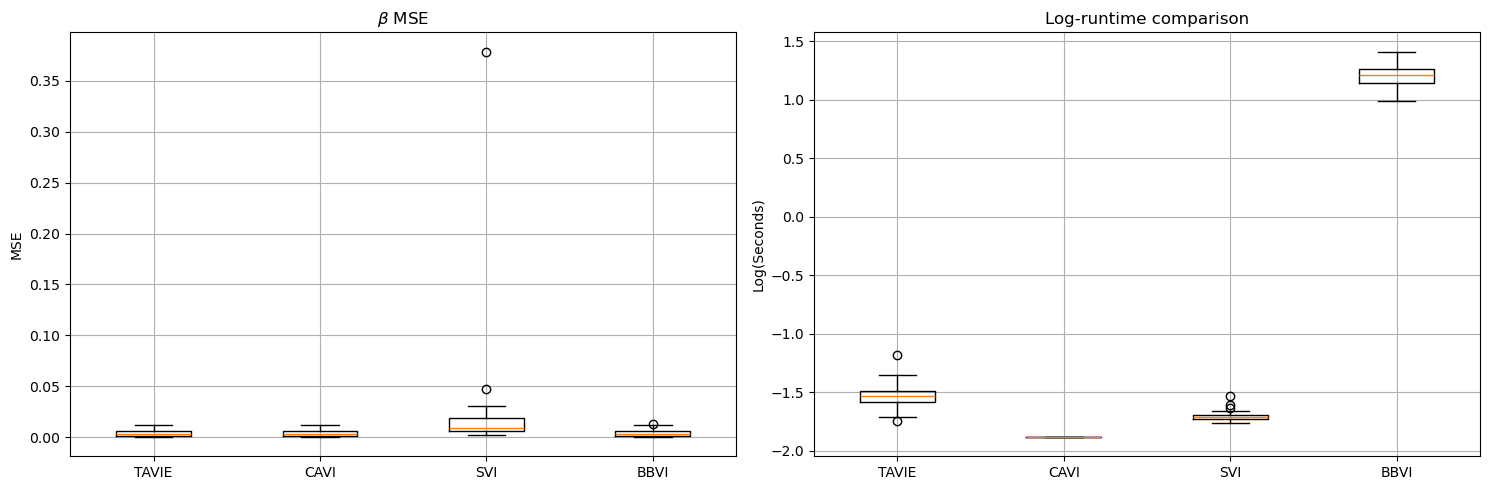

In [12]:
# Plotting results for TAVIE, CAVI, SVI, and BBVI
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Beta MSE comparison
axes[0].boxplot([mse_beta_TAVIE, mse_beta_CAVI, mse_beta_SVI, mse_beta_BBVI], tick_labels=['TAVIE', 'CAVI', 'SVI', 'BBVI'])
axes[0].set_title(r'$\beta$ MSE')
axes[0].set_ylabel('MSE')
#axes[0].set_ylim(0, 0.5)
axes[0].grid(True)

# Runtime comparison
axes[1].boxplot([np.log(time_TAVIE), np.log(time_CAVI), np.log(time_SVI), np.log(time_BBVI)], 
                tick_labels=['TAVIE', 'CAVI', 'SVI', 'BBVI'])
axes[1].set_title('Log-runtime comparison')
axes[1].set_ylabel('Log(Seconds)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Comparing our TAVIE algorithm for Negative-Binomial family (Type II)

**Competing method: black-box variational inference (BBVI)**

In [14]:
# TAVIE model initialization
negbin_model = TAVIE_type_II(family="negbin", fit_intercept=True)

# Experiment parameters
n = 10000
p = 10
r = 20
num_reps = 50

# Containers for metrics
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_BBVI = np.zeros(num_reps)
time_TAVIE = np.zeros(num_reps)
time_BBVI = np.zeros(num_reps)

beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Main loop with progress bar
for rep in trange(num_reps, desc="Repetitions"):
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    linear_term  = beta_true[0] + X @ beta_true[1:len(beta_true)]
    probs = 1 / (1 + np.exp(-linear_term))
    y = np.random.negative_binomial(r, probs, size=n)

    # TAVIE estimator
    t0 = perf_counter()
    negbin_model.fit(X, y, r=r, maxiter = 20000, verbose=False) # Fitting the TAVIE model for Negative-Binomial
    time_TAVIE[rep] = perf_counter() - t0
    beta_est1 = negbin_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est1 - beta_true)**2)
    

    # BBVI estimator
    t0 = perf_counter()
    res2 = BBVI_NegBin(X_bbvi, y, r=r)
    time_BBVI[rep] = perf_counter() - t0
    beta_est2 = res2['beta_mean']
    mse_beta_BBVI[rep] = np.mean((beta_est2 - beta_true)**2)

Repetitions: 100%|██████████████████████████████| 50/50 [04:20<00:00,  5.21s/it]


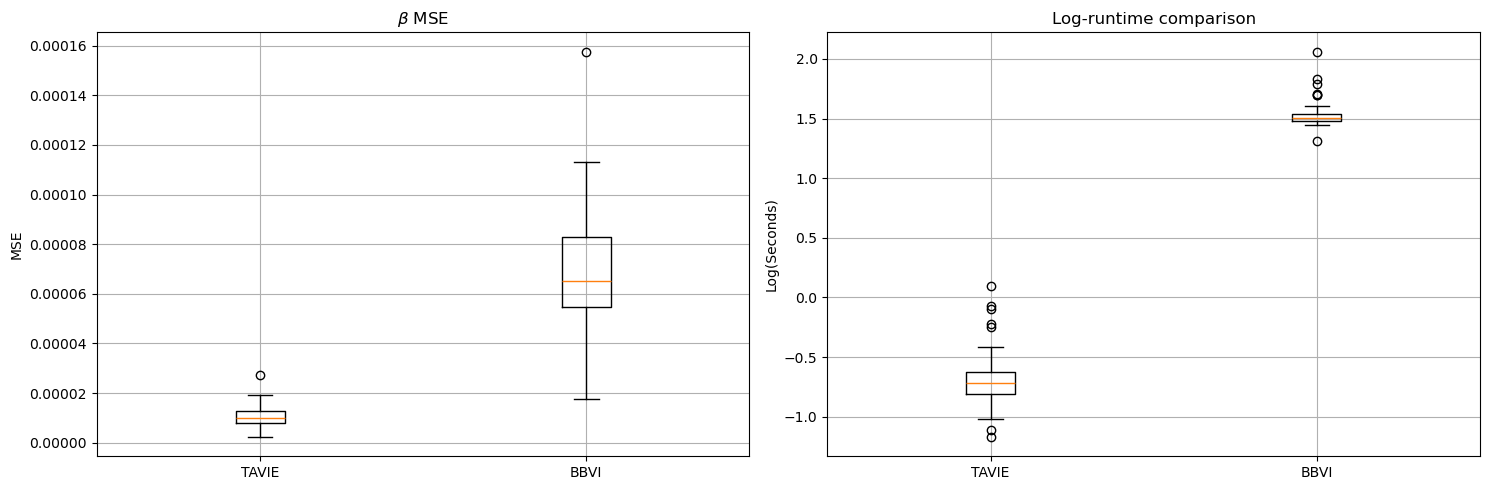

In [15]:
# Plotting results for TAVIE and BBVI
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Beta MSE comparison
axes[0].boxplot([mse_beta_TAVIE, mse_beta_BBVI], tick_labels=['TAVIE', 'BBVI'])
axes[0].set_title(r'$\beta$ MSE')
axes[0].set_ylabel('MSE')
axes[0].grid(True)

# Runtime comparison
axes[1].boxplot([np.log(time_TAVIE), np.log(time_BBVI)], 
                tick_labels=['TAVIE', 'BBVI'])
axes[1].set_title('Log-runtime comparison')
axes[1].set_ylabel('Log(Seconds)')
axes[1].grid(True)

plt.tight_layout()
plt.show()